<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2


## <center> Индивидуальный проект:
## <center> <font color='Chocolate'>Прогнозирование продолжительности поездки нью-йоркского такси</font>
Автор материала: ***Бадамшин Булат Ильдарович***

e-mail: aem-team@ya.ru

slack: Bulat Badamshin



### План.
1. Описание набора данных и решаемая задача.
2. Первичный и визуальный анализ данных.
3. Построение новых признаков.
4. Визуальный анализ всех признаков.
5. Корреляционный анализ признаков.
6. Выбор метрики.
7. Выбор модели.
8. Настройка гиперпараметров модели с помошью библиотеки hyperopt.
9. Построение валидационных, тестовых и тренировочных кривых.
10. Стекинг.
11. Выводы.

## 1. Описание набора данных и решаемая задача

### Задача
**Прогнозирование продолжительности поездки такси в Нью-Йорке**
- Задача является актуальной для оператора такси. Прогнозирование времени поездки позволит оператору  оптимизировать свою работу и улучшить финансовые показатели.
- С точки зрения учебных целей эта работа также представляет большой интерес. В задаче предстоит работать с различными типами данных, в том числе с геораспределенными. Эти данные позволяют генерировать большое клоичество новых признаков. Что выделяет одну из особенностей задачи - возможность построения и исследования большого количества новых признаков.
- Кроме того, организаторы допускают использование дополнительных данных. Так, например, предлагается использовать информацию о погоде в Центральном праке за 2016 год. 
- Объем данных достаточно большой (~1.5 млн записей тренировочной выборки). Что с одной стороны вносит дополнительные требования к вычислительным ресурсам, с другой стороны большой объем данных позволит получить устойчивое решение.

### Описание данных

Данные взяты из kaggle-соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration). 

[Ссылка на данные](https://yadi.sk/d/TSQV2HeU3Pd56P)

Датасет представлен в виде csv-файлов для train и test-выборки. Данные соревнования основаны на источнике о поездках [NYC Yellow Cab](https://cloud.google.com/bigquery/public-data/nyc-tlc-trips) в 2016 году.
- Train-выборка включает 1458644 записей.
- Test-выборка включает 625134 записей.
- Целевая переменная **Trip duration** - продолжительность поездки в секундах.
- Признаки:
    - **id** - уникальный идентификатор поездки;
    - **vendor_id** - идентификатор провайдера;
    - **pickup_datetime** - дата и время включения счетчика;
    - **dropoff_datetime** - дата и время отключения счетчика;
    - **passenger_count** - число пассажиров в машине;
    - **pickup_longitude** - долгота точки, где был включен счетчик;
    - **pickup_latitude** - широта точки, где был включен счетчик;
    - **dropoff_longitude** - долгота точки, где был выключен счетчик;
    - **dropoff_latitude** - широта точки, где был выключен счетчик;
    - **store_and_fwd_flag** - этот флаг показывает была ли задержка в передачи данных о поездке вендору: Y - задержка передачи данных ведору была, N - задержки не было.

В задании подразумевается использование все доступных дополнительных признаков.

## 2. Первичный анализ данных 

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import grid_search
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics
from sklearn.decomposition import PCA

import lightgbm as lgb
#import xgboost as xgb

import pickle
import tqdm

from collections import Counter

import statsmodels.api as sm
from scipy.stats import shapiro

RANDOM_STATE=0

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


#### Загрузим обучающую и тестовую выборки

In [4]:
train = pd.read_csv('../../data/train_NYC_Taxi.csv')
test = pd.read_csv('../../data/test_NYC_Taxi.csv')
print (train.shape, test.shape)
train.head()

(1458644, 11) (625134, 9)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


- train-выборка включает в себя 11 признаков, из которых один целевой. 
- test-выборка включает в себя 9 признаков. Признака dropoff_datetime нет в тестовой выборке.

In [9]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134

(None, None)

In [10]:
train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

- Обучающая и тестовая выборки не имеют пропусков.
- Признак id можно считать категориальным, но скорее всего он не несет полезной информации.
- В обучающей выборке 2 признака типа timestamp, в тестовой один.
- В обеих выборках присутствует бинарные признаки: store_and_fwd_flag и vendor_id.
- Остальные признаки вещественные.

### Проанализируем целевую переменную. 
#### Выбросы по целевой переменной trip_duration
- Для анализа выбросов построим вариационный ряд по целевой переменной

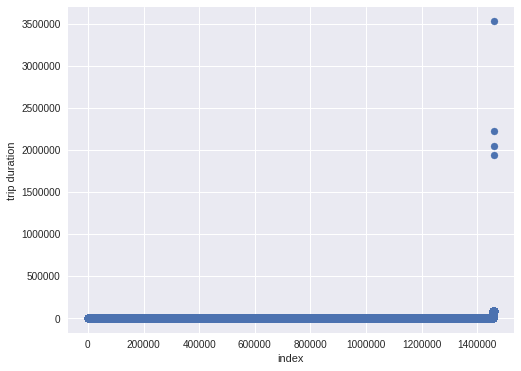

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration))
plt.xlabel('index')
plt.ylabel('trip duration')
plt.show()

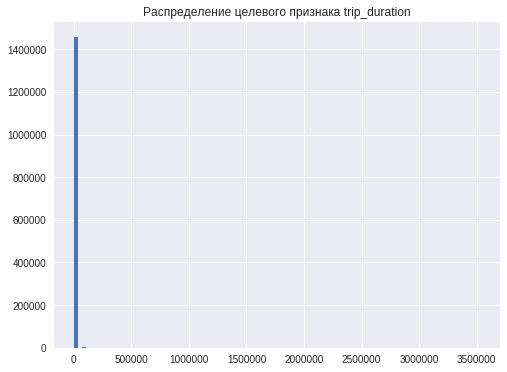

In [17]:
fig, ax =plt.subplots(figsize=(8,6))
ax = train['trip_duration'].hist(bins=100)
ax.set_title('Распределение целевого признака trip_duration');

- На графике вариационного ряда видно, что присутствуют выбросы - аномальные продолжительности поездки. 
- Распределение сильно скошено и выглядит как константное из-за больших значений аномалий.

#### Выкинем из обучающей выборки записи, целевая переменная в которых не попадает в 99% распределения.

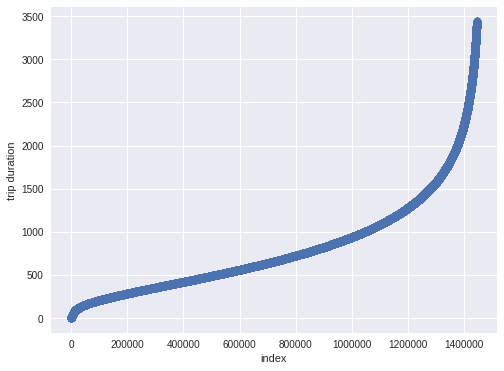

In [4]:
q = train.trip_duration.quantile(0.99)
train = train[train['trip_duration'] < q]

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.trip_duration.values))
plt.xlabel('index')
plt.ylabel('trip duration')
plt.show()

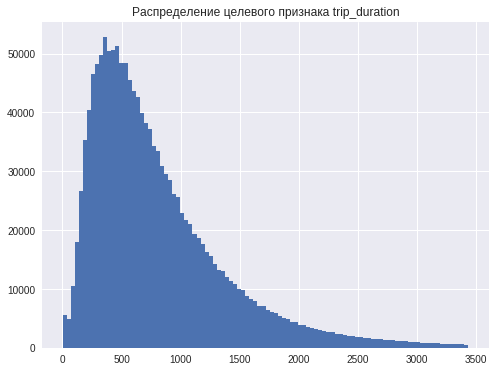

In [15]:
fig, ax =plt.subplots(figsize=(8,6))
ax = train['trip_duration'].hist(bins=100)
ax.set_title('Распределение целевого признака trip_duration');

- После фильтрации выбросов целевой переменной вариационный ряд представляет собой монотоную линию без разрывов (выбросы устранены).
- Распределение стало менее скошенным. Теперь с ним можно работать.

#### Проверка на нормальность распределения целевой переменной с помощью критерия Шапиро-Уилка и QQ-плота

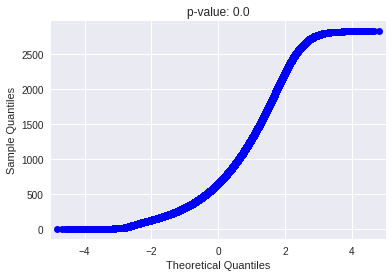

In [23]:
tg = train['trip_duration']
sm.qqplot(tg)
pv = shapiro(tg)[1]
plt.title('p-value: ' + str(pv));

- Гипотеза о нормальности отклонена, так как p-value < 0.05.
- QQ-плот также показывает, что распределение далеко от нормального.

#### Применим логарифмирование для приближения распределения к нормальному

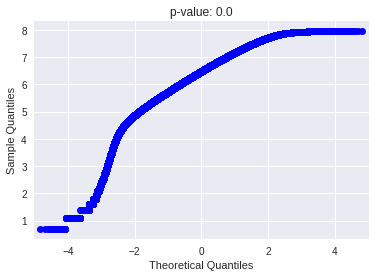

In [24]:
tg = train['trip_duration'].apply(lambda x: np.log(x+1))
sm.qqplot(tg)
pv = shapiro(tg)[1]
plt.title('p-value: ' + str(pv));

- Логарифмирование не помогло. Распределение не стало нормальным

## 3. Построение новых признаков
### Объединим тестовые и обучающие выборки

In [5]:
data = pd.concat([train.drop(['dropoff_datetime','trip_duration'], axis=1),test], axis=0)
data.shape

(2069185, 9)

### Сгенерируем новые признаки из столбца pickup_datetime: 
    - hour - час посадки; 
    - dyear - день в году; 
    - dweek - день недели;
    - weekofyear - неделя в году;
    - minute - минута посадки;
    - week_hour - день недели * 24 + час;
    - dt - отклонение текущего времени посадки от минимального значения в секундах
    - dweek_pass_count - день недели_число пассажиров. Разные дни могут характеризоваться разным кол-вом пассажиров.
    

In [6]:
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)

In [7]:
%%time
data['hour'] = data.pickup_datetime.dt.hour
data['dyear'] = data.pickup_datetime.dt.dayofyear
data['dweek'] = data.pickup_datetime.dt.dayofweek
data['weekofyear'] = data.pickup_datetime.dt.weekofyear
data['minute'] = data['pickup_datetime'].dt.minute
data['week_hour'] = data['dweek'] * 24 + data['hour']
data['dt'] = (data.pickup_datetime - data.pickup_datetime.min()).dt.total_seconds()
data['dweek_pass_count'] = list(map(lambda x,y: x*y, data['dweek'], data['passenger_count']))

CPU times: user 1.52 s, sys: 68 ms, total: 1.58 s
Wall time: 1.56 s


### Кластеризуем координаты посадки и высадки
- число кластеров 100 дало существенное улучшение качества модели

In [7]:
n_clust=100

In [9]:
%%time
#kmeans = KMeans(n_clusters=n_clust, random_state=0)
kmeans = MiniBatchKMeans(n_clusters=n_clust, batch_size=100, random_state=0)
kmeans.fit(data[['pickup_longitude','pickup_latitude']])
cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
data['pickup_cluster'] = kmeans.predict(data[['pickup_longitude','pickup_latitude']])
data['dest_cluster'] = kmeans.predict(data[['dropoff_longitude', 'dropoff_latitude']])

CPU times: user 3.9 s, sys: 12 ms, total: 3.92 s
Wall time: 4.24 s


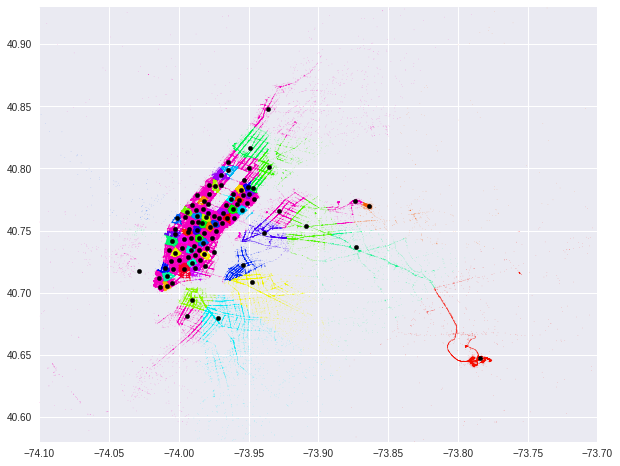

In [10]:
plt.figure(figsize=(10,8))
plt.ylim(40.58, 40.93)
plt.xlim(-74.1,-73.7)

#colors = [np.random.rand(3,1) for i in range(n_clust)]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/n_clust) for i in range(n_clust)]
colored = [colors[k] for k in data['pickup_cluster']]

plt.scatter(data.pickup_longitude, data.pickup_latitude, s=0.01, color = colored)
plt.scatter(cx, cy, s=20, color='black')

plt.show()


- При отображении координат посадки на графике и раскрашивании их по кластерам можно сделать следующие выводы:
    - Наибольшее число посадок в такси приходит на остров Манхэттен, скорее всего из-за того, что исследуются поездки только  "желтого такси" NYC Yellow Cab, за которым закреплен район Манхэттен.
    - В целом кластеры выделяются достаточно четко, что говорит об удачном выборе числа кластеров.
    - Кластеризацию точек высадки пассажиров можно произвести по модели, обученной на точках посадки, так как большинство координат лежат находятся в одном и том же ареале.

### Кодирование категориальных признаков
- Кластеры координат посадки и высадки, а также признак день недели будем кодировать средним значением целевой переменной (trip_duration)

In [10]:
target = train['trip_duration']
train_df = pd.concat([data.iloc[:1444051],target], axis=1)
train_df.shape

(1444051, 20)

In [11]:
data['pickup_cluster_mean'] = 0
data['dest_cluster_mean'] = 0
for cluster in tqdm.tqdm_notebook(range(n_clust)):
    data.at[data['pickup_cluster']==cluster,'pickup_cluster_mean'] = \
    train_df[train_df['pickup_cluster']==cluster]['trip_duration'].mean()
    
    data.at[data['dest_cluster']==cluster,'dest_cluster_mean'] = \
    train_df[train_df['dest_cluster']==cluster]['trip_duration'].mean()
    

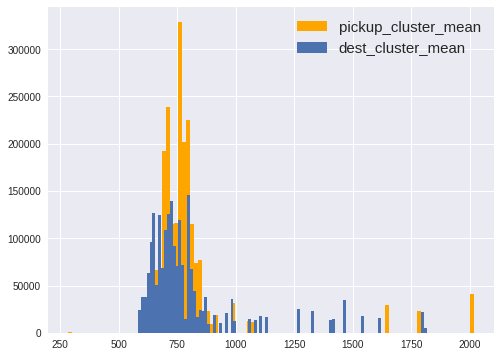

In [14]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax = data['pickup_cluster_mean'].hist(bins=100, color='orange')
ax = data['dest_cluster_mean'].hist(bins=100)
ax.legend(['pickup_cluster_mean', 'dest_cluster_mean'], fontsize=15);

In [12]:
# Также закодируем средним категориальный признак dweek
data['dweek_mean'] = 0
for cluster in tqdm.tqdm_notebook(range(7)):
    data.at[data['dweek']==cluster,'dweek_mean'] = \
    train_df[train_df['dweek']==cluster]['trip_duration'].mean()
    

In [13]:
categor_features = [ 'pickup_cluster_mean', 'dest_cluster_mean', 'dweek_mean']

- Координаты высадки имеют больше значений в правом хвосте, это говорит о том, что чаще посадка совершается в центре, и затем такси отвозит клеента в переферийные районы.

### Новые признаки после PCA преобразования координат. 
- PCA позволяет зеркально отразить координаты, что позволяет получить новые признаки из значений координат.

In [14]:
coords = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,
                    data[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
data['pickup_pca0'] = pca.transform(data[['pickup_latitude', 'pickup_longitude']])[:, 0]
data['pickup_pca1'] = pca.transform(data[['pickup_latitude', 'pickup_longitude']])[:, 1]
data['dropoff_pca0'] = pca.transform(data[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
data['dropoff_pca1'] = pca.transform(data[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

### Признаки расстояний между точками высадки и посадки
- Расстояния между точками на сфере можно рассчитать несколькими способами:
    - Формула гаверсинусов (haversine) для небольших расстояний на сфере.
    - Сферическая теорема косинусов.


In [15]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def cos_dist(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat1)*np.sin(lat2) + np.cos(lng1) * np.cos(lng2) * np.cos(lng)
    h = AVG_EARTH_RADIUS * np.arccos(d)
    return h

In [16]:
data['distance_haversine'] = haversine_array(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)
data['cos_dist'] = cos_dist(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

#### Манхеттенские расстояния для обычных координат и отраженных координат с помощью PCA

In [17]:
data['manhattan'] = np.abs(data['dropoff_latitude'] - data['pickup_latitude']) + np.abs(data['dropoff_longitude'] - data['pickup_longitude'])
data['pca_manhattan'] = np.abs(data['dropoff_pca1'] - data['pickup_pca1']) + np.abs(data['dropoff_pca0'] - data['pickup_pca0'])

#### Дополнительные признаки - центр на прямой линии между точками посадки и высадки

In [18]:
data['center_latitude'] = (data['pickup_latitude'].values + data['dropoff_latitude'].values) / 2
data['center_longitude'] = (data['pickup_longitude'].values + data['dropoff_longitude'].values) / 2

### Признаки: погода
- Информация о [погоде в Центральном парке за 2016 год](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016/data) 

In [11]:
w_data = pd.read_csv('../../data/weather_data_nyc_centralpark_2016(1).csv')
w_data.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [20]:
w_data.date = pd.to_datetime(w_data.date)
# Преобразуем значение T  в признаках - snow fall и precipitation
falls = [ 0.01 if c=='T' else float(c) for c in w_data['snow fall']]
rain = [ 0.01 if c=='T' else float(c) for c in w_data['precipitation']]
w_data['snow fall']= falls
w_data['precipitation'] = rain

In [21]:
w_data['dyear'] = w_data.date.dt.dayofyear

In [22]:
w_data.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,dyear
0,2016-01-01,42,34,38.0,0.0,0.0,0,1
1,2016-02-01,40,32,36.0,0.0,0.0,0,32
2,2016-03-01,45,35,40.0,0.0,0.0,0,61
3,2016-04-01,36,14,25.0,0.0,0.0,0,92
4,2016-05-01,29,11,20.0,0.0,0.0,0,122


In [23]:
w_data['snow depth'] = w_data['snow depth'].apply(lambda x: 1 if x=='T' else float(x))

In [24]:
for col in w_data.columns[3:-1]:
    data[col] = 0.0
    print(col)

average temperature
precipitation
snow fall
snow depth


In [25]:
for day in tqdm.tqdm_notebook(data['dyear'].value_counts().keys(), total = data['dyear'].value_counts().shape[0]):
    for col in w_data.columns[3:-1]:
        data.at[data['dyear'] == day, col] = w_data[w_data['dyear'] == day][col].values[0]

#### Для обучения будем использовать следующие признаки погоды:
- average temperature - средняя температура за день,
- precipitation - количество осадков в виде дождя,
- snow fall	 - количество осадков в виде снега,
- snow depth - глубина снежного покрова

#### Дискретизируем признак dyear и добавим его как новый в основную выборку 

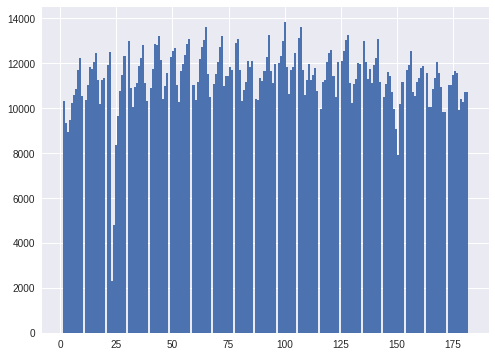

In [26]:
fig = plt.figure(figsize=(8,6))
data['dyear'].hist(bins=200)
plt.show()

- На распределении признака  dyear видно 19 четких кластеров.
- Выделим эти кластеры и закодируем средним по целевой переменной.

In [35]:
new_f = list(map(lambda x: list(map(int, re.findall(r'\d+', x))), pd.qcut(data.dyear, 19).values.astype(str)))
data['new_dyear'] = list(map(lambda x: mean([x[0], x[2]]), new_f))

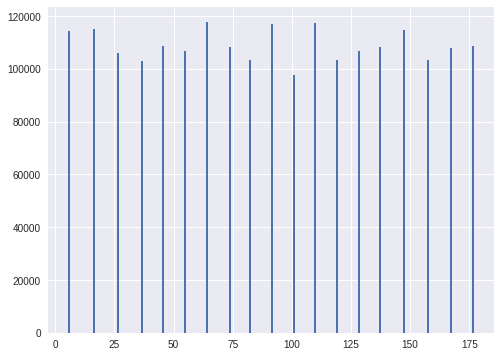

In [36]:
fig = plt.figure(figsize=(8,6))
data['new_dyear'].hist(bins=200)
plt.show()

In [46]:
# Также закодируем средним категориальный признак dweek
target = train['trip_duration']
train_df = pd.concat([data.iloc[:1444051],target], axis=1)

data['new_dyear_mean'] = 0
for cluster in tqdm.tqdm_notebook(data['new_dyear'].value_counts().keys()):
    data.at[data['new_dyear']==cluster,'new_dyear_mean'] = \
    train_df[train_df['new_dyear']==cluster]['trip_duration'].mean()
    

#### Преобразование бинарных признаков

In [29]:
data.store_and_fwd_flag = data.store_and_fwd_flag.apply(lambda x: 1 if x=='N' else 0)
data.store_and_fwd_flag.value_counts()

1    2057955
0      11230
Name: store_and_fwd_flag, dtype: int64

In [30]:
data['vendor_id'] = data['vendor_id'].apply(lambda x: x-1)
data['vendor_id'].value_counts()

1    1105608
0     963577
Name: vendor_id, dtype: int64

### <font color='blue'>Сохраним данные</font>

In [31]:
data.id = data.id.apply(lambda x: int(re.findall(r'\d+', x)[0]))

In [70]:
data.to_hdf('data.h5','df')

In [36]:
train['trip_duration'].to_hdf('target.h5','df')

### <font color='green'>Считаем данные</font>

In [4]:
target = pd.read_hdf('target.h5','df')

In [5]:
data = pd.read_hdf('data.h5','df')

data.shape, target.shape

((2069185, 38), (1444051,))

In [48]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,hour,...,manhattan,pca_manhattan,center_latitude,center_longitude,average temperature,precipitation,snow fall,snow depth,new_dyear,new_dyear_mean
0,2875421,1,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,1,17,...,0.019859,0.020848,40.766769,-73.973392,45.5,0.29,0.0,0.0,73.5,811.724943
1,2377394,0,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,1,0,...,0.026478,0.025622,40.734858,-73.989948,41.5,0.35,0.0,0.0,167.0,821.534378
2,3858529,1,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,1,11,...,0.080158,0.081848,40.737013,-73.992180,22.0,0.00,0.0,1.0,16.0,757.560748
3,3504673,1,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,1,19,...,0.015480,0.016195,40.713345,-74.011154,74.5,0.40,0.0,0.0,92.0,807.788772
4,2181028,1,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,1,13,...,0.010818,0.011271,40.787865,-73.972988,46.5,0.00,0.0,0.0,82.5,774.081962


##  4. Визуальный анализ всех признаков 
#### Анализ распределений признаков

In [41]:
real_features = ['passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'hour', 'dyear',
       'weekofyear', 'minute', 'week_hour', 'dt', 'dweek_pass_count',
                'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'cos_dist',
       'pca_manhattan', 'manhattan', 'center_latitude', 'center_longitude',
       'average temperature', 'precipitation', 'snow fall', 'snow depth']
categor_features = ['pickup_cluster_mean', 'dest_cluster_mean', 'dweek_mean', 'new_dyear_mean']
bin_features = ['vendor_id','store_and_fwd_flag']

In [42]:
feature_names = real_features + categor_features + bin_features

In [43]:
len(feature_names)

32

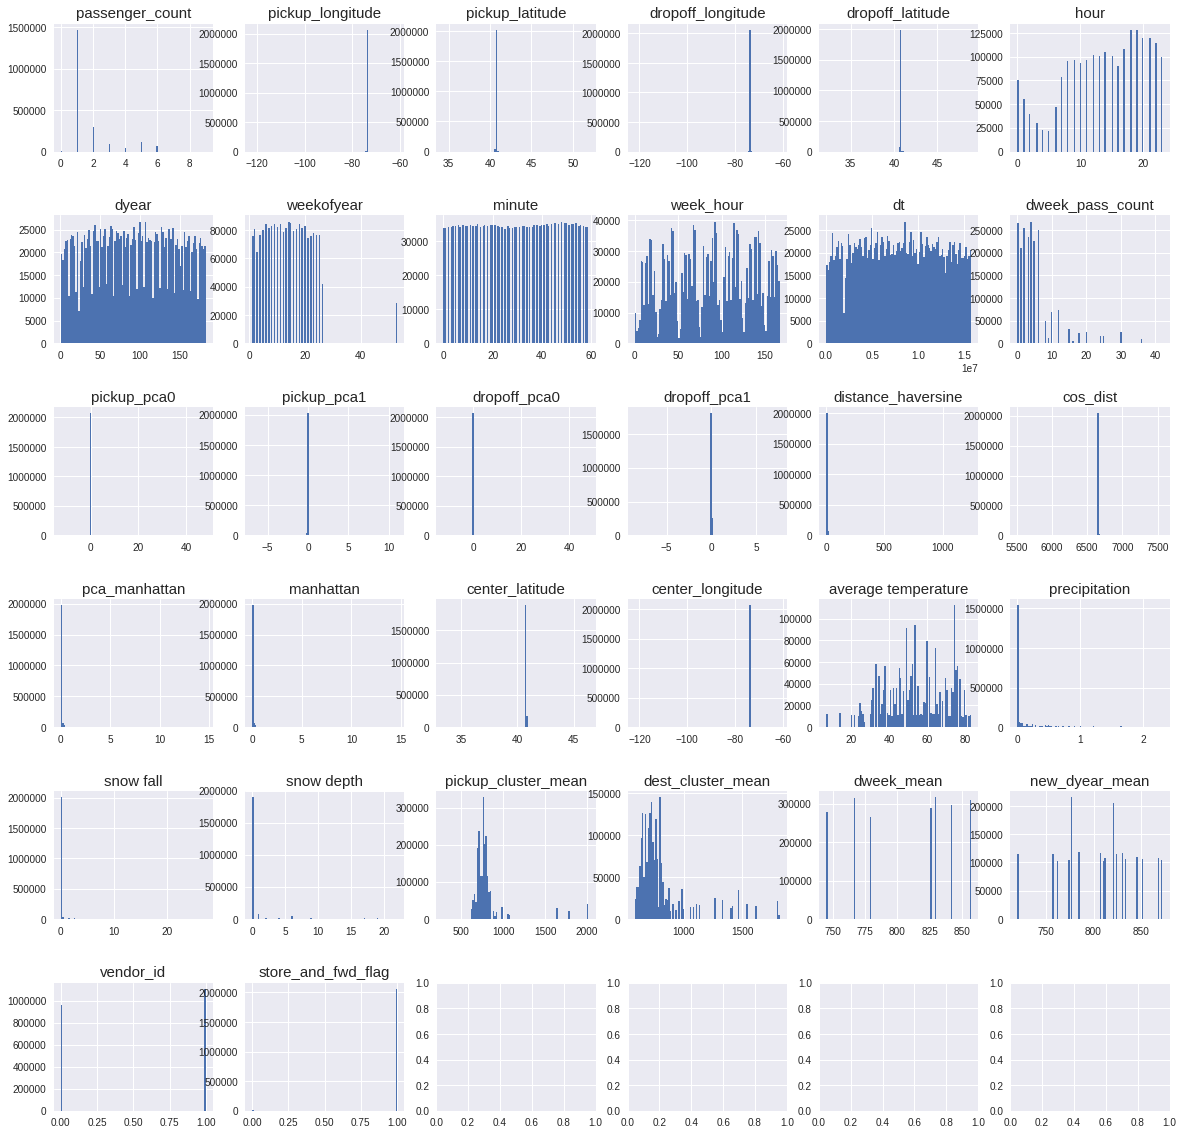

In [49]:
#sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(20,20))
fig.subplots_adjust(hspace=0.5) # Увеличиваем пространство между subplots
for idx, f in enumerate(feature_names):
    ax = axes[int(idx/6),idx%6]
    data[f].hist(ax=ax, bins=100)
    #ax.legend([f], fontsize=10, loc='upper left')
    ax.set_title(f, fontsize=15)
    #ax.set_xlabel('index')
    #ax.set_ylabel(u'Число сессий')
pylab.show()

- Судя по распределениям координатные признаки и признаки на их основе имеют большие выбросы.
- Выбросы по координатам объясняются удаленными районами города, куда таксистам приходится ездить. В то же время основная масса поездок приходится на центральные районы (Манхеттен, Бруклин, аэропорт). 
- Аналогичная ситуация наблюдается с другими признаками, являющимися производными от координатных признаков.
- Координаты высадки 'dest_cluster_mean' имеют больше значений в правом хвосте по сравнению с координатами посадки 'pickup_cluster_mean', это говорит о том, что чаще посадка совершается в центре, и затем такси отвозит клеента в переферийные районы.
- Можно проверить фильтрацию координат посадки и высадки - заменить координаты удаленных районов медианными значениями.
- Кластеризация по координатам позволяет улучшить распределение, сделать его менее скошенным и вариативным. Для линейной модели это может быть критично, но для случайного леса нет.
- Бинарный признак 'store_and_fwd_flag' (флаг задержки в передачи данных о поездке вендору) очень несбалансированный, практически константный. В большинстве случаев задержек в передачи данных не было. Скорее всего он не будет вносить заметный вклад в улучшение качества прогноза.


## 5. Корреляционный анализ признаков

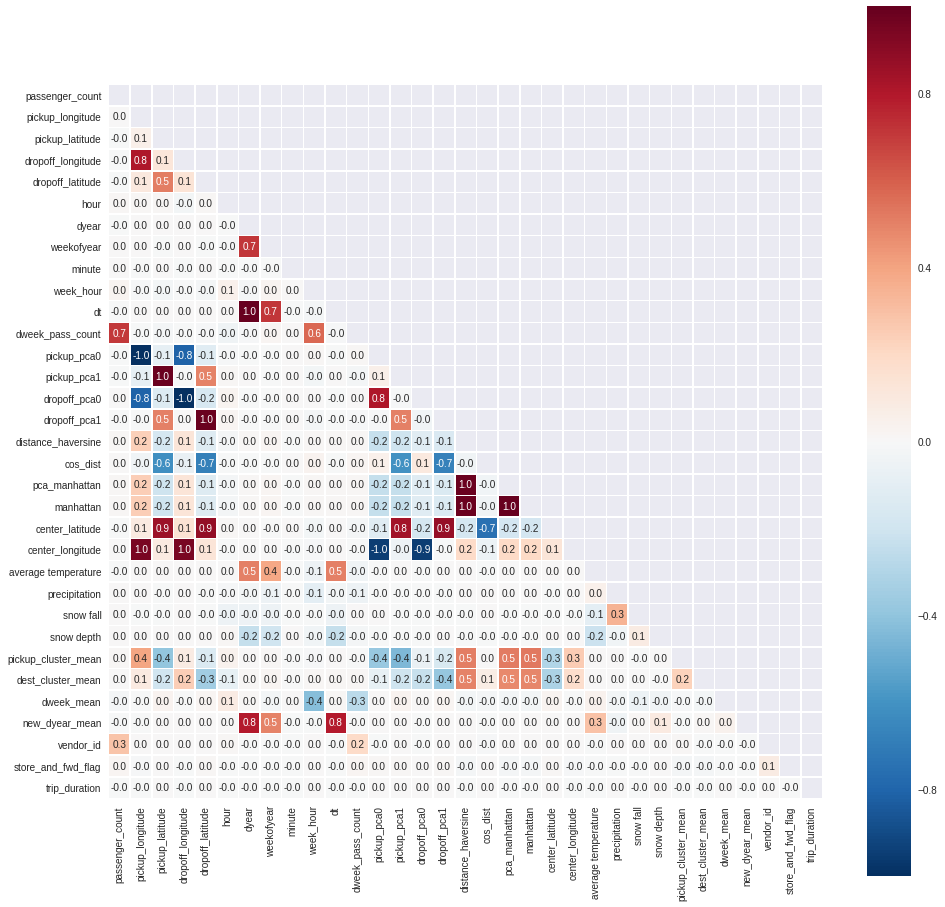

In [50]:
corr_df = data.iloc[:target.shape[0]][feature_names]
corr_df['trip_duration'] = target.values
corr = corr_df[feature_names+['trip_duration']].corr(method='pearson')
# Генерируем маску для отсечения верхней диагонали матрицы
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # Верхнему треугольнику присваиваем True

plt.figure(figsize=(16,16))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": 1});

- На матрице корреляций по Пирсону видны пары признаки с высокой, единичной корреляцией. Что говорит о линейной зависисимости этих признаков. 
- Если избавиться по одному из признаков из каждой такой пары, то можно избежать переобучение на линейных моделях. Но скорее всего линейные модели в этой задаче будут работать гораздо хуже моделей случайного леса и крадиентного бустинга из-за того, что признаки имеют плохие несимметричные распределения с большим количеством выбросов. Но если бы линейная модель была основной, то можно было избавиться от следующих признаков: **'center_longitude', 'pca_manhattan', 'pickup_pca1','dropoff_pca1', 'week_hour', 'dyear'**.
- Также из корреляционной матрицы видно, что нет признаков, которые имеют единичную положительную корреляцию с целевой переменной trip_duration. Наличие такого признака делало бы бессмысленным всю работу по проектированию предсказательной модели.
- В то же время видно, что функции расстояния - гаверсинус ('distance_haversine') и манхеттенская метрика ('pca_manhattan') достаточно сильно коррелируют с целевой переменной, что вполне естественно, поскольку целевая переменная  - это продолжительность поездки в секундах.
- Расстояние расчитанное по сферической теореме косинусов ('cos_dist') не коррелирует с целевой переменной, что может говорить о недостатке этой мере расстояния. [Из википедии:](https://en.wikipedia.org/wiki/Great-circle_distance)В случае маленьких расстояний и небольшой разрядности вычисления (количество знаков после запятой), использование формулы может приводить к значительным ошибкам связанным с округлением. 

## 6. Выбор метрики
В качестве метрики выбрана средняя абсолютная ошибка (MAE):
    - MAE - наиболее удобная метрика для задач регрессии, показывает отклонение в единицах измерения целевой переменной.

## 7. Выбор модели
Рассмотрим несколько типов моделей:
- Случайный лес - подходит в нашем случае, поскольку восстанавливаемая функция скорее всего нелинейная. Также распределения многих признаков далеки от нормальных со множеством выбросов. С такими нетипичными распределениями лучше справляются модели основанные на ансамблях алгоритмов.
- Линейную модель LASSO (L1-регуляризация) попробуем применить для отбора признаков.
- Градиентный бустинг LightGBM - быстрая версия бустинга от Microsoft. Применение быстрой модели позволит на слабой машине проверить Стекинг - способ ансамблирования моделей с построением метапризнаков. Случайный лес со стекингом для конкретной задачи (~1,5 млн записей) в несколько раз увеличивает время расчета.

#### Типы признаков
- В обучении модели не будем использовать признаки: 'dyear', 'dweek', 'pickup_cluster' и 'dest_cluster', так как мы их заменили закодированными средним значением целевой переменной.
- Основную выборку будем делить на обучающую и валидационную в соотношении 70/30 с перемешиванием, так как мы имеем почти 1.5 млн. записей, следовательно, 70% вполне хватит на обучение модели, а 30% - хороший объем для валидации.

In [51]:
real_features = ['passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'hour', 
       'weekofyear', 'minute', 'week_hour', 'dt', 'dweek_pass_count',
                'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'cos_dist',
       'pca_manhattan', 'manhattan', 'center_latitude', 'center_longitude',
       'average temperature', 'precipitation', 'snow fall', 'snow depth']
categor_features = ['pickup_cluster_mean', 'dest_cluster_mean', 'dweek_mean', 'new_dyear_mean']
bin_features = ['vendor_id','store_and_fwd_flag']

### RandomForestRegressor
- Возьмем в качестве базовой модели Случайный лес

In [69]:
feature_names = real_features + categor_features + bin_features

In [76]:
X_full = data[feature_names].values
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
X.shape, y.shape, X_tst.shape

((1444051, 31), (1444051,), (625134, 31))

In [77]:
# Разобъем выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1010835, 31), (433216, 31), (1010835,), (433216,))

In [78]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

In [79]:
%%time
rf = RandomForestRegressor(n_estimators = 30,
                           max_depth = 10,
                           random_state=RANDOM_STATE)
mean_score = cross_val_score(rf, X_train, y_train, cv=kfold, n_jobs=-1, scoring = 'neg_mean_absolute_error').mean()
print ('mae: {}'.format(mean_score))

mae: -202.35252728664412
CPU times: user 2.66 s, sys: 264 ms, total: 2.92 s
Wall time: 12min 50s


- Случайный лес работает слишком долго на таком объеме данных.
- Проверим с помощью линейной модели LASSO значимость признаков и затем попробуем применить отобранные значимые признаки на базовой модели случайного леса.

### Масштабирование признаков

In [54]:
# Вещественные признаки
scaler = StandardScaler()
X_full = scaler.fit_transform(data[real_features+categor_features])
X_full.shape

(2069185, 29)

In [55]:
# Бинарные признаки
X_full = np.concatenate((X_full,data[bin_features].values), axis=1)
X_full.shape

(2069185, 31)

In [61]:
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
X.shape, y.shape, X_tst.shape

((1444051, 31), (1444051,), (625134, 31))

In [62]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_scaled_train.shape, X_scaled_test.shape, y_train.shape, y_test.shape

((1010835, 31), (433216, 31), (1010835,), (433216,))

### Линейная модель
#### Анализ значимости признаков с помощью модели Lasso

In [63]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

In [64]:
%%time
lasso = LassoCV(cv = kfold, n_jobs=-1)
lasso.fit(X_scaled_train, y_train)

CPU times: user 25 s, sys: 11.1 s, total: 36.1 s
Wall time: 39.3 s


In [65]:
mean_absolute_error(y_test, lasso.predict(X_scaled_test))

294.50634775795231

In [66]:
feature_names = real_features + categor_features + bin_features

In [67]:
# Функция, возвращающая веса линейной модели, убывающие по абсолютному значению
def getCoefficients(model):    
    coefs = pd.DataFrame(model.coef_, feature_names)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

In [68]:
getCoefficients(lasso)

,coef
distance_haversine,312.085795
dest_cluster_mean,46.558004
pickup_cluster_mean,45.904874
dweek_mean,29.965103
new_dyear_mean,17.172992
center_latitude,-6.281487
hour,5.164692
manhattan,4.031976
cos_dist,0.000000
vendor_id,0.000000


In [69]:
good_features = ['distance_haversine', 'dest_cluster_mean', 'pickup_cluster_mean', 'dweek_mean', 
                 'new_dyear_mean', 'hour', 'center_latitude', 'manhattan']

### Проверим как изменилась ошибка базового случайного леса на отобранных значимых признаках good_features

In [11]:
X_full = data[good_features].values
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
# Разобъем выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE)

In [14]:
%%time
rf = RandomForestRegressor(n_estimators = 30,
                           max_depth = 10,
                           random_state=RANDOM_STATE)
mean_score = cross_val_score(rf, X_train, y_train, cv=kfold, n_jobs=-1, scoring = 'neg_mean_absolute_error').mean()
print ('mae: {}'.format(mean_score))

mae: -205.37410133601458
CPU times: user 1.02 s, sys: 168 ms, total: 1.19 s
Wall time: 4min 41s


- Lasso метод выкинул значащие признаки, так как MAE повысилась после обучения на неполной выборке. 

### Попробуем улучшить качество за счет фильтрация выбросов некоторых признаков
- Заменим едианными значениями выбросы по координатам

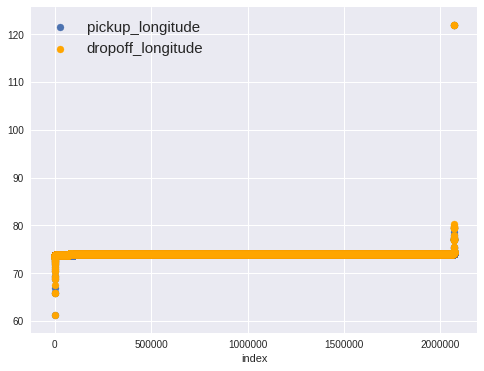

In [37]:
plt.figure(figsize=(8,6))
plt1 = plt.scatter(range(data.shape[0]), np.sort(data['pickup_longitude'].apply(np.abs)))
plt2 = plt.scatter(range(data.shape[0]), np.sort(data['dropoff_longitude'].apply(np.abs)), color='orange')
plt.xlabel('index')
plt.legend([plt1, plt2], ['pickup_longitude', 'dropoff_longitude'], fontsize=15);

In [38]:
data.at[data['pickup_longitude'] < -85.0, 'pickup_longitude'] = data['pickup_longitude'].median()
data.at[data['dropoff_longitude'] < -85.0, 'dropoff_longitude'] = data['pickup_longitude'].median()

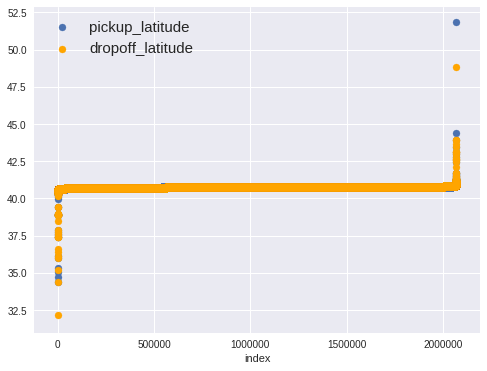

In [39]:
plt.figure(figsize=(8,6))
plt1 = plt.scatter(range(data.shape[0]), np.sort(data['pickup_latitude']))
plt2 = plt.scatter(range(data.shape[0]), np.sort(data['dropoff_latitude']), color='orange') 
plt.xlabel('index')
plt.legend([plt1, plt2], ['pickup_latitude', 'dropoff_latitude'], fontsize=15);

In [40]:
data.at[data['pickup_latitude'] > 45.0, 'pickup_latitude'] = data['pickup_latitude'].median()
data.at[data['dropoff_latitude'] > 45.0, 'dropoff_latitude'] = data['dropoff_latitude'].median()

#### Обучим базовую модель RandomForest на отфильтрованных данных

In [43]:
feature_names = real_features + categor_features + bin_features

In [45]:
X_full = data[feature_names].values
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
# Разобъем выборку на обучающую и валидационную
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=RANDOM_STATE)

In [48]:
%%time
rf = RandomForestRegressor(n_estimators = 30,
                           max_depth = 10,
                           random_state=RANDOM_STATE)
mean_score = cross_val_score(rf, X_train, y_train, cv=kfold, n_jobs=-1, scoring = 'neg_mean_absolute_error').mean()
print ('mae: {}'.format(mean_score))

mae: -202.4213366353691
CPU times: user 3.98 s, sys: 420 ms, total: 4.4 s
Wall time: 19min 53s


- Ошибка практически не изменилась по сравнению с результатом на неотфильтрованных данных (mae: -202.35252728664412)

### LightGBM
- Попробуем улучшить результат за счет применения градиентного бустинга
- Будем использовать реализацию бустинга от Microsoft - LightGBM, которая значительно быстрее традиционного XGBoost. Использование быстрой модели позволит обучать множество вариантов моделей с различными гиперпапраметрами и усреднять результаты.

In [71]:
real_features = ['passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'hour', #'dyear', #'dweek',
       'weekofyear', 'minute', 'week_hour', 'dt', 'dweek_pass_count',
                'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'cos_dist',
       'manhattan', 'center_latitude', 'center_longitude', 'pca_manhattan', 
       'average temperature', 'precipitation', 'snow fall', 'snow depth'
                ]
categor_features = ['pickup_cluster_mean', 'dest_cluster_mean', 'dweek_mean', 'new_dyear_mean']
bin_features = ['vendor_id','store_and_fwd_flag']

#### Деление выборки

In [72]:
feature_names = real_features + categor_features + bin_features
#feature_names = good_features

In [73]:
X_full = data[feature_names].values

In [74]:
X=X_full[:1444051]
X_tst = X_full[1444051:]
y = target.values
X.shape, y.shape, X_tst.shape

((1444051, 31), (1444051,), (625134, 31))

In [75]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, 
                                                     random_state=7)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1010835, 31), (433216, 31), (1010835,), (433216,))

#### Модель LightGBM с праметрами по умолчанию

In [111]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:265.562706614055


- Пока качество хуже случайного леса "из коробки".
- Но попробуем настроить гиперпараметры.

## 8. Настройка гиперпараметров модели с помошью библиотеки hyperopt
- Выборка очень большая, более 1 млн. строк, поэтому обойдемся без кросс-валидации. Валидироваться будем просто на отложенной выборке один раз.

In [50]:
from hyperopt import hp
from hyperopt import fmin, Trials, tpe

In [68]:
def hyperopt_objective(params):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators = params['num_est'],
            max_depth = params['max_dpth'],
            num_leaves = params['num_lvs'],
            learning_rate = params['lrn_rate'],
            reg_alpha = params['reg_alph'],
            reg_lambda = params['reg_lmbd'],
            objective='regression',
            nthread=-1
        )    
    model.fit(X_train, y_train)
    mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
    return mae

In [70]:
params_space = {
    'num_est': hp.choice('num_est', (4000,4500,5000,5500,6000)), 
    'max_dpth': hp.choice('max_dpth', (30,33,35,38)),
    'num_lvs': hp.choice('num_lvs', (15,18,20,23,27)),
    'lrn_rate': hp.uniform('lrn_rate', 0.2, 0.4),
    'reg_alph': hp.uniform('reg_alph', 10, 50),
    'reg_lmbd': hp.uniform('reg_lmbd', 10, 50)
}

In [71]:
%%time
trials = Trials()
best_params = fmin(
    hyperopt_objective,
    space=params_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    verbose = 2
)

CPU times: user 1d 7h 35min 6s, sys: 1min 34s, total: 1d 7h 36min 41s
Wall time: 7h 58min 4s


In [72]:
best_params

{'lrn_rate': 0.2029823209429007,
 'max_dpth': 3,
 'num_est': 3,
 'num_lvs': 4,
 'reg_alph': 43.63743528388524,
 'reg_lmbd': 42.56637567284501}

In [105]:
# Сохраним лог hyperopt
with open('hyperopt_trials.pkl', 'wb') as hyp_trl:
    pickle.dump(trials.trials, hyp_trl)

#### Пример лога поиска оптимальных параметров с помощью hyperopt:

In [91]:
trials.trials[0]

{'book_time': datetime.datetime(2017, 11, 10, 19, 52, 50, 523000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'lrn_rate': [0],
   'max_dpth': [0],
   'num_est': [0],
   'num_lvs': [0],
   'reg_alph': [0],
   'reg_lmbd': [0]},
  'tid': 0,
  'vals': {'lrn_rate': [0.3057488956574924],
   'max_dpth': [1],
   'num_est': [3],
   'num_lvs': [2],
   'reg_alph': [40.69034076946591],
   'reg_lmbd': [13.034331279444196]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 11, 10, 19, 57, 54, 863000),
 'result': {'loss': 157.39614957269134, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}

#### График ошибки на отложенной выборке, который показывает как hyperopt подбирал параметры

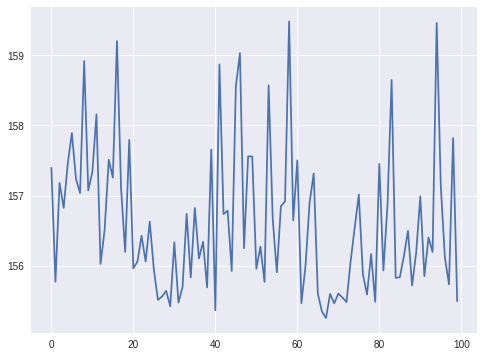

In [109]:
plt.figure(figsize=(8,6))
plt.plot(range(len(trials.losses())), trials.losses());

- Судя по графику поиск происходил случайным образом

In [107]:
min(trials.losses())

155.2550627993237

#### Обучение на оптимальных гиперпараметрах

In [63]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:155.03589145692152


- Видим заметное улучшение качества прогнозирования за счет подбора потимальных гиперпараметров модели с помощью бибилиотеки hyperopt по сравнению с дeфолтной моделью lightgbm (MAE:265.562706614055)

## 9. Построение валидационных, тестовых и тренировочных кривых.
- Перебор 100 комбинаций гиперпараметров lightgbm занял около 8 часов. Столь длительное время объясняется главным образом количеством деревьев (от 4000 до 6000). Построение же кросс-валидационных кривых для такого количества деревьев может занять в несколько раз больше времени. Поэтому было принято решение построить валидационные кривые только для параметров 'max_dpth' и 'num_lvs' для 1000 деревьев, и оценить по ним как обучается модель.

In [64]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = RANDOM_STATE)

#### Кривые валидации, тестовая и тренировочная для разных значений параметра ***max_depth***

In [90]:
train_mae = []
valid_mae = []
test_mae = [] 
max_depth_grid = [10,40,60,80,100]

# Обучаем на тренировочном датасете
for depth in tqdm.tqdm_notebook(max_depth_grid):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=1000,
            max_depth=depth,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    temp_train_mae = []
    temp_valid_mae = []
    temp_test_mae = []
    for train_index, valid_index in kfold.split(X_train, y_train):
        X_trn, X_vld = X_train[train_index], X_train[valid_index]
        y_trn, y_vld = y_train[train_index], y_train[valid_index]
        model.fit(X_trn, y_trn)
        temp_train_mae.append(metrics.mean_absolute_error(y_trn, model.predict(X_trn)))
        temp_valid_mae.append(metrics.mean_absolute_error(y_vld, model.predict(X_vld)))
    train_mae.append(temp_train_mae)
    valid_mae.append(temp_valid_mae)
    test_mae.append(metrics.mean_absolute_error(y_valid, model.predict(X_valid)))


In [91]:
def plot_cv_trn_tst(train_mae, valid_mae, test_mae, grid, label):
    train_mae, valid_mae, test_mae = np.asarray(train_mae), np.asarray(valid_mae), np.asarray(test_mae)
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(grid, train_mae.mean(axis=1), alpha=0.5, color='blue', label='train')
    ax.plot(grid, valid_mae.mean(axis=1), alpha=0.5, color='red', label='cv')
    ax.fill_between(grid, valid_mae.mean(axis=1) - valid_mae.std(axis=1), valid_mae.mean(axis=1) + valid_mae.std(axis=1), color='#888888', alpha=0.4)
    ax.fill_between(grid, valid_mae.mean(axis=1) - 2*valid_mae.std(axis=1), valid_mae.mean(axis=1) + 2*valid_mae.std(axis=1), color='#888888', alpha=0.2)
    ax.plot(grid, test_mae, alpha=0.5, color='orange', label='test')
    ax.legend(loc='best', fontsize=15)
    #ax.set_ylim([0.88,1.02])
    ax.set_ylabel("MAE", fontsize=15)
    ax.set_xlabel(label, fontsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    ax.set_title('CV, train, test-curves', fontsize=20);

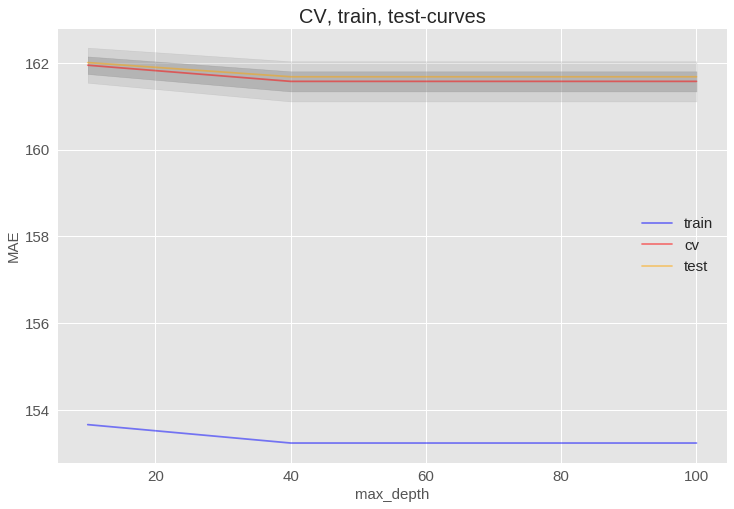

In [92]:
plot_cv_trn_tst(train_mae, valid_mae, test_mae, max_depth_grid, 'max_depth')

- Видно, что после  'max_depth' = 40 качество модели не улучшается. То есть, параметр, подобранный функцийе hyperopt является оптимальным.

#### Кривые валидации, тестовая и тренировочная для разных значений параметра ***num_leaves***

In [76]:
train_mae = []
valid_mae = []
test_mae = [] 
num_lvs_grid = [40,50,55,60,65]

# Обучаем на тренировочном датасете
for lvs in tqdm.tqdm_notebook(num_lvs_grid):
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=1000,
            max_depth=40,
            num_leaves=lvs,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    temp_train_mae = []
    temp_valid_mae = []
    temp_test_mae = []
    for train_index, valid_index in kfold.split(X_train, y_train):
        X_trn, X_vld = X_train[train_index], X_train[valid_index]
        y_trn, y_vld = y_train[train_index], y_train[valid_index]
        model.fit(X_trn, y_trn)
        temp_train_mae.append(metrics.mean_absolute_error(y_trn, model.predict(X_trn)))
        temp_valid_mae.append(metrics.mean_absolute_error(y_vld, model.predict(X_vld)))
    train_mae.append(temp_train_mae)
    valid_mae.append(temp_valid_mae)
    test_mae.append(metrics.mean_absolute_error(y_valid, model.predict(X_valid)))


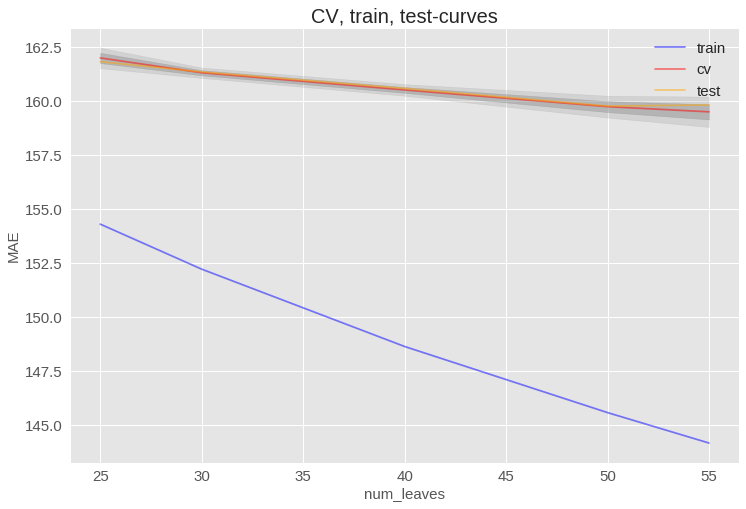

In [83]:
plot_cv_trn_tst(train_mae, valid_mae, test_mae, num_lvs_grid, 'num_leaves')

- Видно, что после значения параметра 'num_leaves' = 50 тестовая кривая перестает снижаться. Поэтому на этом значении 'num_leaves' стоит остановиться. 

#### Проверим качество модели на отложенной выборке с количеством деревьев, найденных с помощью hyperopt

In [76]:
model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=50,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
model.fit(X_train, y_train)        
mae = metrics.mean_absolute_error(y_valid, model.predict(X_valid))
print('MAE:{}'.format(mae))

MAE:154.98340115188805


- Качество немного улучшилось без риска переобучения.
- Оставим эти гиперпараметры и попробуем применить Стекинг.

## 10. Стекинг
- Идея стекинга заключается в генерировании метапризнаков с помощью некоторой базовой модели и использование полученных метапризнаков совместно с основной выборкой в итоговой метамодели: [Методы ансамблирования обучающихся алгоритмов](http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf)
- В текущем проекте использовался модифицированный вариант стекинга, когда деление исходной выборки осуществлялось методом bootstrap.
- В качестве метамодели и основной модели использовалась LightGBM.
- Из-за большого объема исходных данных стекинг на большом количестве bootstrap-выборок занимает очень много времени на среднем по производительности PC. В то же время даже на трех bootstrap-выборках удалось добиться существенного снижения ошибки. 
- Во время обучения стекинг осуществлялся в 2 прохода для разных значений random_state, а полученные результаты 2-х моделей усреднялись. Такой подход также привел к снижению ошибки.

In [76]:
# Разбиение с помощью bootstrap
def get_bootstrap_samples(X, y, n_samples):  
    X_train_1 = []
    y_train_1 = []
    X_train_2 = []
    y_train_2 = []
    # генерируем матрицу индексов подвыборок из генеральной выборки
    indices = np.random.randint(0, y.size, (n_samples, y.size)) 
    # массив выборок
    j=0
    for i in range(int(n_samples/2)):
        X_train_1.append(X[indices[j]])
        y_train_1.append(y[indices[j]])
        X_train_2.append(X[indices[j+1]])
        y_train_2.append(y[indices[j+1]])  
        j += 2
    return X_train_1, y_train_1, X_train_2, y_train_2


In [77]:
# Модель LightGBM с предварительно настроенными гиперпараметрами
def lgbm_model():
    model = lgb.LGBMRegressor(
            seed=RANDOM_STATE,
            n_estimators=5500,
            max_depth=38,
            num_leaves=27,
            learning_rate=0.2029823209429007,
            reg_alpha=43.63743528388524,
            reg_lambda=42.56637567284501,
            objective='regression',
            nthread=-1
        )
    return model

In [78]:
KK = [3] # количество выборок bootstrap
y_pred_best = None
meta_mae_0 = inf

basic_mae = []
meta_mae = []
y_pred = []
seed = [42,7] # Варианты сидов
n_samples = len(seed)
for i in tqdm.tqdm_notebook(range(n_samples)):
    np.random.seed(seed[i])
    kk = KK[0] 
    X_train_1, y_train_1, X_train_2, y_train_2 = get_bootstrap_samples(X, y, kk*2)
    
    for k in tqdm.tqdm_notebook(range(kk)):
        # Обучим базовую модель на выборке X_train_1, y_train_1
        bst = lgbm_model()
        bst.fit(X_train_1[k], y_train_1[k])
                
        # make prediction
        basic_mae.append(metrics.mean_absolute_error(y_valid, bst.predict(X_valid)))   

        # Предсказание обученного алгоритма для выборок X_train_2 и X_valid. Метапризнаки
        MF2 = bst.predict(X_train_2[k])
        MF0 = bst.predict(X_valid)
        MF_tst = bst.predict(X_tst)

        # Получим новую обучающую выборку (объединим X_train_2 c метапризнаком MF2)
        new_train = np.concatenate((X_train_2[k],MF2.reshape(MF2.size, 1)), axis=1)

        # Получим новую валидационную выборку (объединим X_valid c метапризнаком MF0)
        new_valid = np.concatenate((X_valid,MF0.reshape(MF0.size, 1)), axis=1)

        # Получим новую тестовую выборку (объединим X_tst c метапризнаком MF_tst)
        new_tst = np.concatenate((X_tst,MF_tst.reshape(MF_tst.size, 1)), axis=1)

        # Обучим метамодель        
        meta_model = lgbm_model()
        meta_model.fit(new_train, y_train_2[k])

        meta_mae.append(metrics.mean_absolute_error(y_valid, meta_model.predict(new_valid)))
        
        y_pred.append(meta_model.predict(new_tst))

basic_mean = mean(basic_mae)
meta_mean = mean(meta_mae)

print ('basic_mean: {}, meta_mean: {}'.format(basic_mean, meta_mean))




basic_mean: 140.60101719388723, meta_mean: 123.96648039023809


In [122]:
print('{}%'.format(round((100*(155 - meta_mean)/155),0)))

20.0%


- Стекинг позволил снизить MAE на 20% (123.9) по сравнению с моделью LightGBM с просто настроенными параметрами.

### Подготовка данных для отправки на kaggle.com

In [80]:
predictions = np.vstack(y_pred).T
predictions = predictions.mean(axis=1)
test['trip_duration'] = predictions.astype(int)

In [81]:
# Проверка на NAN
test['trip_duration'].isnull().values.any()

False

In [83]:
test['trip_duration'] = test['trip_duration'].apply(lambda x: x*(-1) if x<0 else x)

In [84]:
# Load to csv
test[['id','trip_duration']].to_csv('submit_.csv', index=False)

#### Резултат на kaggle (метрика Root Mean Squared Logarithmic Error):
- Private score: 0.39744 

## 11. Выводы.
- В процессе анализа признаков было сгенерировано большое количество временных и гео-признаков. Анализ этих признаков позволяет получить много информации об особенностях транспортных пассажирских перевозках в исследуемой локации. То есть, помимо решенной задачи прогнозирования поездки, эта работа позволяет сделать выводы по дальнейшему улучшению качества поездок.
- Далеко не все признаки сделали существенный вклад в итоговый прогноз. Но это не всегда говорит о том, что признак бесполезен. Часто грамотное кодирование признака и применение подходящей модели позволяет извлечь из него много полезной информации.
- Настройка гиперапраметров модели LightGBM позволило получить результат существенно лучше случайного леса и линейных моделей.
- Применение технологии стекинга (обучение на метапризнаках) позволило снизить ошибку на 20% по сравнению с моделью, для которой осуществлялась только настройка параметров.
- Дальнейшее развитие модели:
    - Так как в задаче используются распределенные в пространстве данные, то можно представить признаковое пространство в виде геораспределенной сетки и применить сверточную сеть по аналогии с изображением.
    - Преимуществом такого подхода будет в том, что нейронная сеть сама будет выявлять дополнительные признаки и зависимости, что позволит уменьшить сложность подготовительной части проекта, связанной с анализом признаков.
    
    